In [1]:
import numpy as np
import cv2
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
from skimage.feature import hog
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
%matplotlib inline

# print(sklearn.__version__)

car_folder = './vehicles/vehicles'
car_sub_folders = ['./GTI_Far/', './GTI_Left/', './GTI_MiddleClose/', './GTI_Right/', './KITTI_extracted/']

non_car_folder = './non-vehicles/non-vehicles'
non_car_sub_folders = ['./Extras/', './GTI/']

cars = []
notcars = []

for car_sub_folder in car_sub_folders:
    if not 'KITTI' in car_sub_folder:
        images = glob.glob(car_folder + car_sub_folder + 'image*.png')
    else:
        images = glob.glob(car_folder + car_sub_folder + '*.png')
    for image in images:
        cars.append(image)

print(len(cars))
        
for non_car_sub_folder in non_car_sub_folders:
    if not 'GTI' in non_car_sub_folder:
        images = glob.glob(non_car_folder + non_car_sub_folder + 'extra*.png')
    else:
        images = glob.glob(non_car_folder + non_car_sub_folder + 'image*.png')
    for image in images:
        notcars.append(image)
    
print(len(notcars))



8792
8968


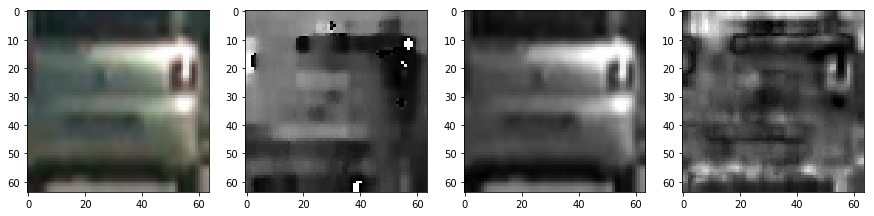

In [2]:
original = (np.array(mpimg.imread(cars[400]))*255).astype(np.uint8)

hsv = cv2.cvtColor(original, cv2.COLOR_RGB2HSV)
H = hsv[:,:,0]
S = hsv[:,:,1]
V = hsv[:,:,2]

plt.figure(figsize=(15,15))
plt.subplot(141)
plt.imshow(original)
plt.subplot(142)
plt.imshow(H, cmap='gray')
plt.subplot(143)
plt.imshow(V, cmap='gray')
plt.subplot(144)
plt.imshow(S, cmap='gray')

In [3]:
def convert_color(img, color='YCrCb'):
    if color == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if color == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if color == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if color == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channels=[0],
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = (np.array(mpimg.imread(file))*255).astype(np.uint8)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            hog_features = []
            for channel in hog_channels:
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [4]:
def make_list(start, end, n=5):
        return np.linspace(start, end, n, dtype=np.int)


[  0  27 216]
[1280 1253 1064]


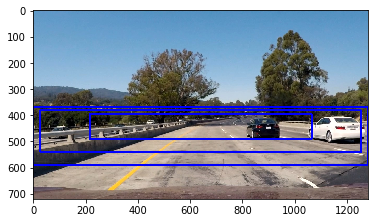

In [5]:
image = mpimg.imread('./test_images/test1.jpg')

n_window_layers = 3

max_box_size = 130
min_box_size = 64

box_size_list = make_list(max_box_size, min_box_size, n_window_layers)

x1_0 = 0
y1_0 = 370
x2_0 = image.shape[1]
y2_0 = 590

x1_end = 220
y1_end = 395
y2_end = y1_end + min_box_size*3//2

x1 = make_list(x1_0, np.cbrt(x1_end), n_window_layers)**3
y1 = make_list(y1_0, y1_end, n_window_layers)
x2 = x2_0 - x1
y2 = make_list(y2_0, y2_end, n_window_layers)

for i in range(n_window_layers):
    cv2.rectangle(image, (x1[i], y1[i]), (x2[i], y2[i]), (0,0,255), 6)

plt.imshow(image)

print(x1)
print(x2)

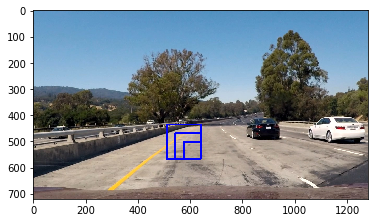

In [6]:
image = mpimg.imread('./test_images/test1.jpg')

box_size_list = make_list(max_box_size, min_box_size, n_window_layers)

for i in range(n_window_layers):
    test_box = ((int(image.shape[1]/2-box_size_list[i]), int(680/1.2-box_size_list[i])), (int(image.shape[1]/2), int(680/1.2)))
    cv2.rectangle(image, test_box[0], test_box[1], (0,0,255), 6)

plt.imshow(image)

In [7]:
from sklearn.svm import LinearSVC

color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 32  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channels = [0, 1, 2] # Can be 0, 1, 2, or "ALL"
spatial_size = (4, 4) # Spatial binning dimensions
hist_bins = 4    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t1 = time.time()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channels=hog_channels, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channels=hog_channels, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print('Feature extraction took', round(t2-t1, 2), 'seconds.')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


C:\Users\jsa\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Feature extraction took 103.02 seconds.


In [8]:
from sklearn.model_selection import GridSearchCV

user_input = input('Train the classifier? (y/[n]) ')

if user_input == 'y':
    print('Training...')
    # Use a linear SVC (support vector classifier)
#     parameters = {'C':[0.005, 0.01, 0.05, 0.1]}
#     svr = LinearSVC()
#     svc = GridSearchCV(svr, parameters)
    svc = LinearSVC(C=1/10000)
    t_train_svc=time.time()
    # Train the SVC
    svc.fit(X_train, y_train)
    t_train_svc2=time.time()
    print(round(t_train_svc2-t_train_svc, 2), 'Seconds to train SVC...')
    
    # save the classifier
    with open('vehicle_classifier.pkl', 'wb') as fid:
        pickle.dump(svc, fid)
        
else:
    # load it again
    with open('vehicle_classifier.pkl', 'rb') as fid:
        svc = pickle.load(fid)
        
# Check accuracy
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Train the classifier? (y/[n]) 
Test Accuracy of SVC =  0.9989


In [9]:
# print(svc.best_params_)

In [10]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [22]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channels, spatial_size, hist_bins):
    
    window_img = np.copy(img)
    
    n_window_layers = 3
    max_box_size = 130
    min_box_size = 64
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window_size = 64
    cells_per_step = 2  # Instead of overlap, define how many cells to step

    box_size_list = make_list(max_box_size, min_box_size, n_window_layers)
    
    x1_0 = 0
    y1_0 = 380
    x2_0 = image.shape[1]
    y2_0 = 590

    x1_end = 220
    y1_end = 395
    y2_end = y1_end + min_box_size*3//2

    x1 = make_list(x1_0, np.cbrt(x1_end), n_window_layers)**3
    y1 = make_list(y1_0, y1_end, n_window_layers)
    x2 = x2_0 - x1
    y2 = make_list(y2_0, y2_end, n_window_layers)
    
    hot_windows = []
    
    for i in range(n_window_layers):
#         if i == n_window_layers-1:
#             cells_per_step = cells_per_step // 2
        
        ystart = y1[i]
        ystop = y2[i]
        xstart = x1[i]
        xstop = x2[i]
        
        img_tosearch = img[ystart:ystop,xstart:xstop,:]
        ctrans_tosearch = convert_color(img_tosearch, color=color_space)
    
        scale = box_size_list[i]/64
        
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        # Define blocks and steps as above
        nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        nblocks_per_window = (window_size // pix_per_cell) - cell_per_block + 1
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hogs = []
        for channel in hog_channels:
            hogs.append(get_hog_features(ctrans_tosearch[:,:,channel], orient, pix_per_cell, cell_per_block, feature_vec=False))

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat = []
                for ch_i in range(len(hog_channels)):
                    hog_i = hogs[ch_i]
                    hog_feat.append(hog_i[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())
                
                hog_features = np.array(hog_feat).ravel()

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window_size, xleft:xleft+window_size], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window_size*scale)
                    window = ((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart))
                    hot_windows.append(window)
                    cv2.rectangle(window_img,window[0],window[1],(0,0,255),6)
                    
    return window_img, hot_windows


took 0.45 seconds...
took 0.41 seconds...
took 0.42 seconds...
took 0.4 seconds...
took 0.42 seconds...
took 0.43 seconds...


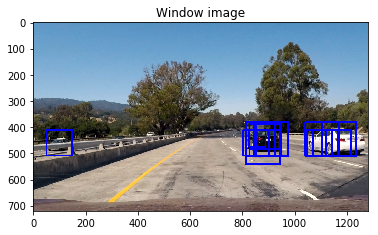

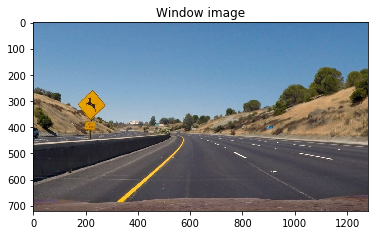

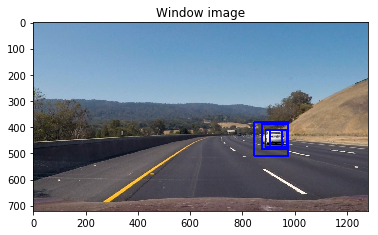

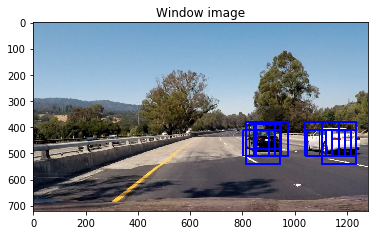

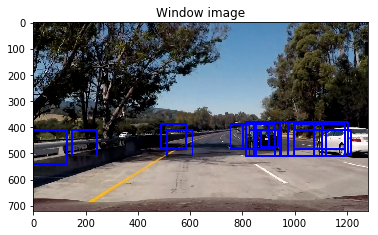

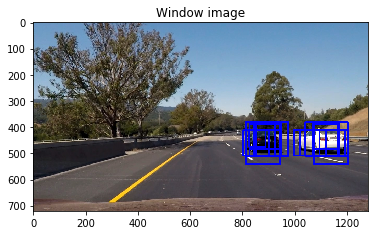

In [23]:
test_images = glob.glob('./test_images/test*.jpg')
output_folder = './output_images/'
n_images = len(test_images)

for file_i in range(n_images):
    image = mpimg.imread(test_images[file_i])
    
    t1 = time.time()
    window_img, hot_windows = find_cars(image, svc, X_scaler, color_space, 
                                          orient, pix_per_cell, cell_per_block, 
                                          hog_channels, spatial_size, hist_bins)
    '''
    mpimg.imsave(output_folder + 'window' + str(file_i+1) + '.jpg', window_img)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    heat = add_heat(heat, hot_windows)
    
    mpimg.imsave(output_folder + 'heat' + str(file_i+1) + '.jpg', heat, cmap='hot')
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    mpimg.imsave(output_folder + 'heatmap' + str(file_i+1) + '.jpg', heatmap, cmap='hot')

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
        
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    mpimg.imsave(output_folder + 'bboxes' + str(file_i+1) + '.jpg', draw_img)
    '''
    
    t2 = time.time()
    print('took', round(t2-t1, 2), 'seconds...')

    fig = plt.figure()
#     plt.subplot(131)
    plt.imshow(window_img)
    plt.title('Window image')
#     plt.subplot(132)
#     plt.imshow(heatmap, cmap='hot')
#     plt.title('Heat Map')
#     plt.subplot(133)
#     plt.imshow(draw_img)
#     plt.title('Car Positions')
    
    

In [24]:
from collections import deque

class Car_windows:
    def __init__(self):
        self.n_frames = 7
        self.recent_windows = deque(maxlen=self.n_frames)
        self.count = 0
        self.heat_th = 7
        

In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

car_windows = Car_windows()

def process_images(image, car_windows=car_windows):
    
    window_img, hot_windows = find_cars(image, svc, X_scaler, color_space, 
                                                      orient, pix_per_cell, cell_per_block, 
                                                      hog_channels, spatial_size, hist_bins)
    
    if hot_windows:
        car_windows.recent_windows.append(hot_windows)
        car_windows.count = min(car_windows.count + 1, car_windows.n_frames)
    else:
        if (car_windows.count == car_windows.n_frames) and list(car_windows.recent_windows):
            car_windows.recent_windows.popleft()
        
    most_recent_windows = list(car_windows.recent_windows)    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    if most_recent_windows:
        for window_i in range(len(most_recent_windows)):
            heat = add_heat(heat, most_recent_windows[window_i])
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, car_windows.heat_th)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
        
    out_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return out_img

In [26]:
test_video_output = './output_images/output_test_video.mp4'

clip2 = VideoFileClip("./test_video.mp4")
test_clip = clip2.fl_image(process_images) #NOTE: this function expects color images!!
%time test_clip.write_videofile(test_video_output, audio=False)

[MoviePy] >>>> Building video ./output_images/output_test_video.mp4
[MoviePy] Writing video ./output_images/output_test_video.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:17<00:00,  2.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/output_test_video.mp4 

Wall time: 19 s


In [27]:
project_video_output = './output_images/output_project_video.mp4'

clip1 = VideoFileClip("./project_video.mp4")
project_clip = clip1.fl_image(process_images) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./output_images/output_project_video.mp4
[MoviePy] Writing video ./output_images/output_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [09:22<00:00,  2.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/output_project_video.mp4 

Wall time: 9min 24s
